In [1]:
# Generic stuff
import time
import os, sys,glob, numpy as np, pandas as pd
from scipy.io import loadmat
from itertools import product
from scipy.interpolate import interp1d
from copy import deepcopy

import torch
from sbi import utils as utils
from sbi.inference.base import infer
from sbi import analysis as analysis

    
# Viz stuff
%matplotlib inline
from matplotlib import pyplot as plt

# CTWC model code
sys.path.append('../ctwc')

from ctwc_model_DP import run_net_sim

filename = "samples_fit_Gs.npy"

N_RUNS = 3
N_SIMULATIONS = 500
N_SAMPLES_PER_RUN = 1000
N_WORKERS = 5
Gs = np.array([0.0, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0, 50.0, 100.0])

eta = -0.1 # -0.05

T = 2**12
dt = 0.1


In [2]:
# path = '/home/docker/packages/tvb-multiscale/examples/data/cerebellum/PS_popa2013'
path = '/Users/dionperd/Software/TVB/tvb-multiscale/examples/data/cerebellum/PS_popa2013'

psd_m1 = np.load(os.path.join(path, "PSD_M1.npy"))
psd_s1 = np.load(os.path.join(path, "PSD_S1.npy"))

In [3]:
f = np.arange(5.0, 48.0, 1.0)
psd_m1_targ = np.interp(f, psd_m1[:, 0], psd_m1[:, 1])
psd_s1_targ = np.interp(f, psd_s1[:, 0], psd_s1[:, 1])
psd_targ = (psd_m1_targ + psd_s1_targ) / 2
psd_targ_norm = psd_targ / psd_targ.sum()


Text(0, 0.5, 'log(PS)')

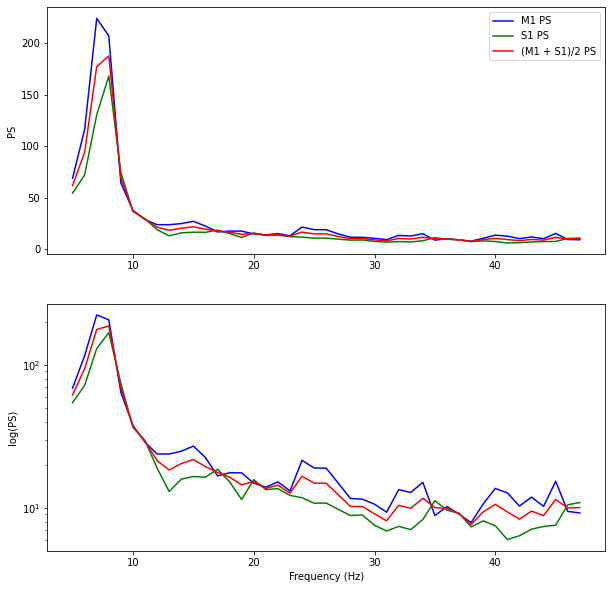

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].plot(f, psd_m1_targ, "b", label='M1 PS')
axes[0].plot(f, psd_s1_targ, "g", label='S1 PS')
axes[0].plot(f, psd_targ, "r", label='(M1 + S1)/2 PS')
axes[0].set_ylabel('PS')
axes[0].legend()
axes[1].semilogy(f, psd_m1_targ, "b", label='M1 PS')
axes[1].semilogy(f, psd_s1_targ, "g", label='S1 PS')
axes[1].semilogy(f, psd_targ, "r", label='(M1 + S1)/2 PS')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('log(PS)')


In [5]:
# # 1-node weights & delays
# weights = np.array([[1.]])
# delays = np.array([[10.]])

def prepare_params(g=0.0):
    
    # 2-nodes' weights & delays
    weights = np.array([[0.0, 1.0], [1.0, 0.0]])
    delays = np.array([[0.0, 10.0], [10.0, 0.0]])

    sc = 1/dt

    #g = 0.0  # 5.0
    I_o = -0.25

    stim_amp = 0.25                        #stimulation amplitude
    i_e = -0.35 #  -1.0 # -0.75            #constant current of excittory population 
    i_th = 0.5 + I_o                       #consant current of thalamic exitatory populatin 
    wie = -3.0 # -4.0 # -2.0 #  -3.0 #     #inhibitory coupling for the cortical population
    wrtnth = -2.                           #inhibitory coupling for the thalamic population
    a_e = 0.9/sc # 0.3  # 0.9 #            #Time constants , the higher those number are the faster is the system 
    a_i = 0.9/sc # 0.5  # 0.9 #
    a_th = 0.25/sc # 0.2 # 0.25 #
    a_rtn = 0.25/sc # 0.2 # 0.25 #
        
    wee = 1.4 # 0.5 # 1.4 #
    wei = 1.4 # 1.0 # 1.4 #
    
    noise = 1e-4  # 1e-5

    # eta = -0.1 # -0.05
    cfe0 = -0.208
    cfi0 = -0.165 - 0.22259977802616615
    thf0 = -0.192
    rtnf0 = -0.226 - 0.6462250103410804

    ssX_params = dict(I_o=0.0,
                      wee = wee,
                      wei = wei,
                      wie = wie, 
                      wii = -0.5, # wie = -2.,wii = -0.5,
                      wertn = 0.6, weth = .6, wthi = 0.2, wthe = 1.65, wrtnth = wrtnth, wthrtn = 2.,
                      D_e = noise,D_i= noise,D_th = noise,D_rtn = noise,
                      T=int(sc*T), #T = 1024*4,# 20,
                      P=1,Q = 1, Dt = 0.001/sc,
                      dt = 0.1, gain = 20., threshold = 0., Pi = 3.14159,
                      g = g, # 10., # 1., #-0.9,
                      a_e = a_e, 
                      a_i = a_i, 
                      a_th=a_th, 
                      a_rtn=a_rtn, # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2,
                      i_e = i_e,
                      i_i = -0.3, 
                      i_th = i_th, 
                      i_rtn = -0.8,
                      tau1 = sc*20.,
                      tau2 = sc*5., 
                      T_transient=int(sc*1000),
                      stim_amp=stim_amp, 
                      stim_freq=6.0, stim_type='sinewave', stim_pops=['th'],
                      weights=weights,
                      delays=delays,
                      K=weights.shape[0], #stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'], #weights=_df_w.values,delays=_df_d.values,K=83,
                      return_ts=True,
                      compute_connectivity=False ,
                      f=f,
                      eta=eta, 
                      cfe0=cfe0, cfi0=cfi0, thf0=thf0, rtnf0=rtnf0
                     )#True) #False
    
    priors_params = dict(zip(["stim_amp", "i_e", "i_th", "wie", "wrtnth", "a_e", "a_i", "a_th", "a_rtn"], 
                             [stim_amp, i_e, i_th, wie, wrtnth, a_e, a_i, a_th, a_rtn]))
    
    return ssX_params, priors_params



In [6]:
def run_sim_for_sbi(priors, priors_params_names, params={}, return_ts=False):
    
    p = params.copy()
    
    for prior, pname in zip(priors, priors_params_names):  # 'noise'             
        try:
            numpy_prior = prior.numpy()
        except:
            numpy_prior = prior  
        if pname == 'noise':
            for noise in ['D_e', 'D_i', 'D_th','D_rtn']:
                p[noise] = 10**numpy_prior
        else:
            p[pname] = numpy_prior

    f = p.pop('f')
    
    res = run_net_sim(**p)
    
    # Periodogram PS:
    ssX_pps = res[2].copy()
    ssX_pps = ssX_pps['e'].loc[f[0]:f[-1] + 1.0].mean(axis=1)
    ssX_pps = np.interp(f, ssX_pps.index.values, ssX_pps.values)
    ssX_pps = ssX_pps / ssX_pps.sum()
    
    # Time series
    if return_ts:
        ssX_ts = res[0].copy()
        ssX_ts.columns= ssX_ts.columns.swaplevel(0)
        ssX_ts = ssX_ts[0]
        return  ssX_pps, ssX_ts 
    else:
        return  ssX_pps
    
    
def model_sbi_fit(iG):
    
    g = Gs[iG]
    
    ssX_params, priors_params = prepare_params(g)
    priors_params_names = list(priors_params.keys())
    run_sim_for_sbi_for_g = lambda priors: run_sim_for_sbi(priors, priors_params_names, 
                                                           params=ssX_params, return_ts=False)
    
    print("\n\nFitting for G = %g!\n" % g)
    
    # normal or uniform priors:
    #             0.   1.     2.     3.     4.     5.    6.    7.      8.  
    #        stim_amp, i_e,   i_th,  wie,  wrtnth, a_e,  a_i,  a_th,  a_rtn
    prior_min = [0.1, -1.0,   0.0] #, -10.0] #, -5.0] #,   0.03, 0.03, 0.01,  0.01]  # 
    prior_max = [0.5,  0.0,   1.0] #,  0.0] #,   0.0] #,   0.15, 0.15, 0.05,  0.05]  # 
#     
    prior_loc = [0.25, -0.5,  0.5] #,  -5.0] #,  -2.5] #,  0.09, 0.09, 0.025, 0.025]  # #Question :What those prameters refers to ?
    prior_sc =  [0.1,   0.25, 0.25] #,  2.5] #,  1.25] #, 0.03, 0.03, 0.005, 0.005]  # , 0.5 #loc ==>location of the center of the distibution
    #prior_sc : refers to the scale how much the distribution is stretched around the center prior_loc 'variance'
    
    n_priors = len(prior_min)
    
#     priors_normal = torch.distributions.Normal(loc=torch.as_tensor(prior_loc), 
#                                                scale=torch.as_tensor(prior_sc)) #create a gaussian normal distribution 
# #with parameters loc :The Location paramet tells you where the distribution is centered on the horizontal axis.
# #The Scale parameter gives you an idea of the scale on the horizontal axis. For example, the scale parameter on a standard normal distribution is equal to one standard deviation (σ).
# #It usually stretches or squeezes a graph

#     priors = torch.distributions.Independent(priors_normal, 1) #Me :useful for changing the shape of the result

# or
# #     priors = torch.distributions.MultivariateNormal(loc=torch.as_tensor(prior_loc), 
# #                                                     scale_tril=torch.diag(torch.as_tensor(prior_sc)))

    priors = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                         high=torch.as_tensor(prior_max))
    # samples_fit = torch.Tensor()
    # posterior = torch.Tensor()
    for iR in range(N_RUNS):
        print("\n Run %d...\n" %  iR)
        tic = time.time()
    #priors : a prior distribution that allows to sample parameter sets
    #run_sim_for_sbi_for_g :a simulator that takes parameter sets and produces simulation outputs
        posterior= infer(run_sim_for_sbi_for_g, 
                      priors, method='SNPE', num_simulations=N_SIMULATIONS, num_workers=N_WORKERS) #posterior prob p(teta/x)
        print("\nDone in %g sec!" % (time.time() - tic))
    
        print("\nSampling posterior...")

        if iR:
            samples_fit = torch.cat((samples_fit, posterior.sample((N_SAMPLES_PER_RUN,), x=psd_targ_norm)), 0)
        else:
            samples_fit = posterior.sample((N_SAMPLES_PER_RUN,), x=psd_targ_norm) 
        
        if os.path.isfile(filename):
            samples_fit_Gs = np.load(filename, allow_pickle=True).item()
        else:
            samples_fit_Gs = {}
        samples_fit_Gs[g] = {}
        samples_fit_Gs[g]['samples'] = samples_fit.numpy()
        samples_fit_Gs[g]['mean'] = samples_fit.mean(axis=0).numpy()
        np.save(filename, samples_fit_Gs, allow_pickle=True)
        print("\nSamples' mean:\n%s" % str(dict(zip(priors_params_names, samples_fit_Gs[g]['mean']))))
        
        print("\nPlotting posterior...")
        limits = []
        for pmin, pmax in zip(prior_min, prior_max):
            limits.append([pmin, pmax])
        fig, axes = analysis.pairplot(samples_fit,
                                  limits=limits,
                                  ticks=limits,
                                  figsize=(10,10),
                                  points=np.array(list(priors_params.values())),  # , -4
                                  points_offdiag={'markersize': 6},
                                  points_colors=['r']*n_priors);
                  
        print("\nSimulating with posterior means...")
        ssX_pps, ssX_ts = run_sim_for_sbi(samples_fit_Gs[g]['mean'], priors_params_names, 
                                          ssX_params, return_ts=True)
                    
    f = ssX_params['f']
    fig1, axes1 = plt.subplots(2, 1, figsize=(10, 10))
    # ssX_pps = ssX_pps / ssX_pps.sum()
    axes1[0].plot(f, ssX_pps, "b", label='Simulation')
    axes1[0].plot(f, psd_targ_norm, "r", label='Target')
    axes1[0].set_ylabel('PSD')
    axes1[0].legend()
    axes1[1].semilogy(f, ssX_pps, "b", label='Simulation')
    axes1[1].semilogy(f, psd_targ_norm, "r", label='Target')
    axes1[1].set_xlabel('Frequency (Hz)')
    axes1[1].set_ylabel('log(PSD)')
    
    time_vals = ssX_ts['e'].index.values
    fig2, axes2 = plt.subplots(4, 1, figsize=(20, 10))
    ssX_ts['e'].plot(ax=axes2[0])
    me = ssX_ts['e'].mean()
    axes2[0].plot([time_vals[0], time_vals[-1]], [me]*2, 'r')
    axes2[0].set_title('e\nm=%g' % me)
    ssX_ts['i'].plot(ax=axes2[1])
    mi = ssX_ts['i'].mean()
    axes2[1].plot([time_vals[0], time_vals[-1]], [mi]*2, 'r')
    axes2[1].set_title('i\nm=%g' % mi)
    ssX_ts['th'].plot(ax=axes2[2])
    mth = ssX_ts['th'].mean()
    axes2[2].plot([time_vals[0], time_vals[-1]], [mth]*2, 'r')
    axes2[2].set_title('th\nm=%g' % mth)
    ssX_ts['rtn'].plot(ax=axes2[3])
    mrtn = ssX_ts['rtn'].mean()
    axes2[3].plot([time_vals[0], time_vals[-1]], [mrtn]*2, 'r')
    axes2[3].set_title('rtn\nm=%g' % mrtn)
    axes2[3].set_xlabel('Time (ms)')
    fig2.tight_layout()
    
    print("\n-----------------------------------------------------------------\n")
                                  
    return samples_fit_Gs, ((fig, axes), (fig1, axes1), (fig2, axes2))
    

In [7]:
samples = []
figs = []




Fitting for G = 0!


 Run 0...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 41 epochs.
Done in 953.354 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.23285504, 'i_e': -0.17734984, 'i_th': 0.25211355}

Plotting posterior...

Simulating with posterior means...

 Run 1...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 56 epochs.
Done in 1006.39 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.24616522, 'i_e': -0.18404514, 'i_th': 0.2546288}

Plotting posterior...

Simulating with posterior means...

 Run 2...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 58 epochs.
Done in 1314.7 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.23782939, 'i_e': -0.17091537, 'i_th': 0.24807142}

Plotting posterior...

Simulating with posterior means...

-----------------------------------------------------------------



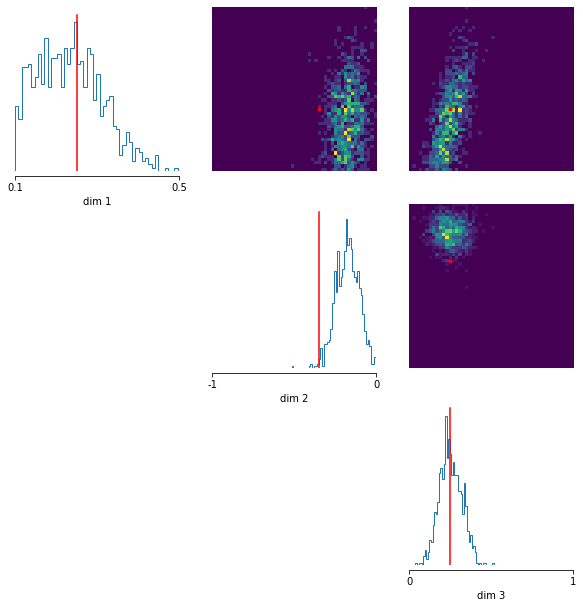

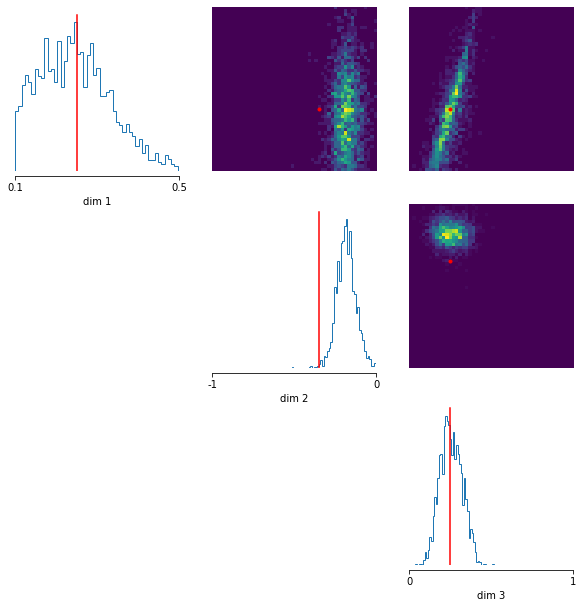

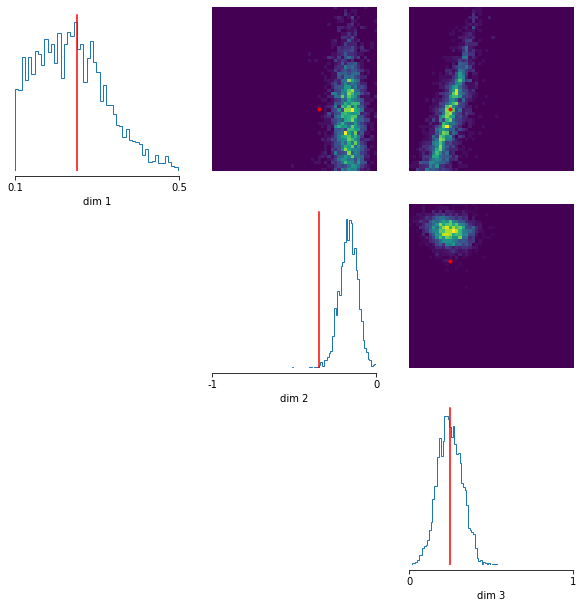

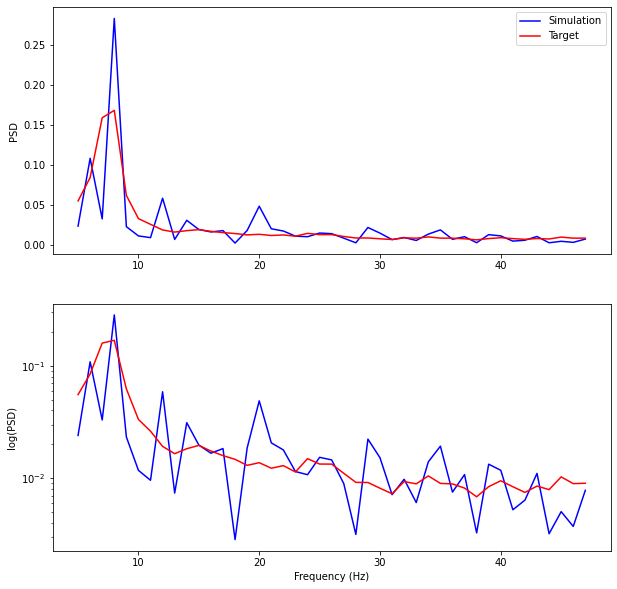

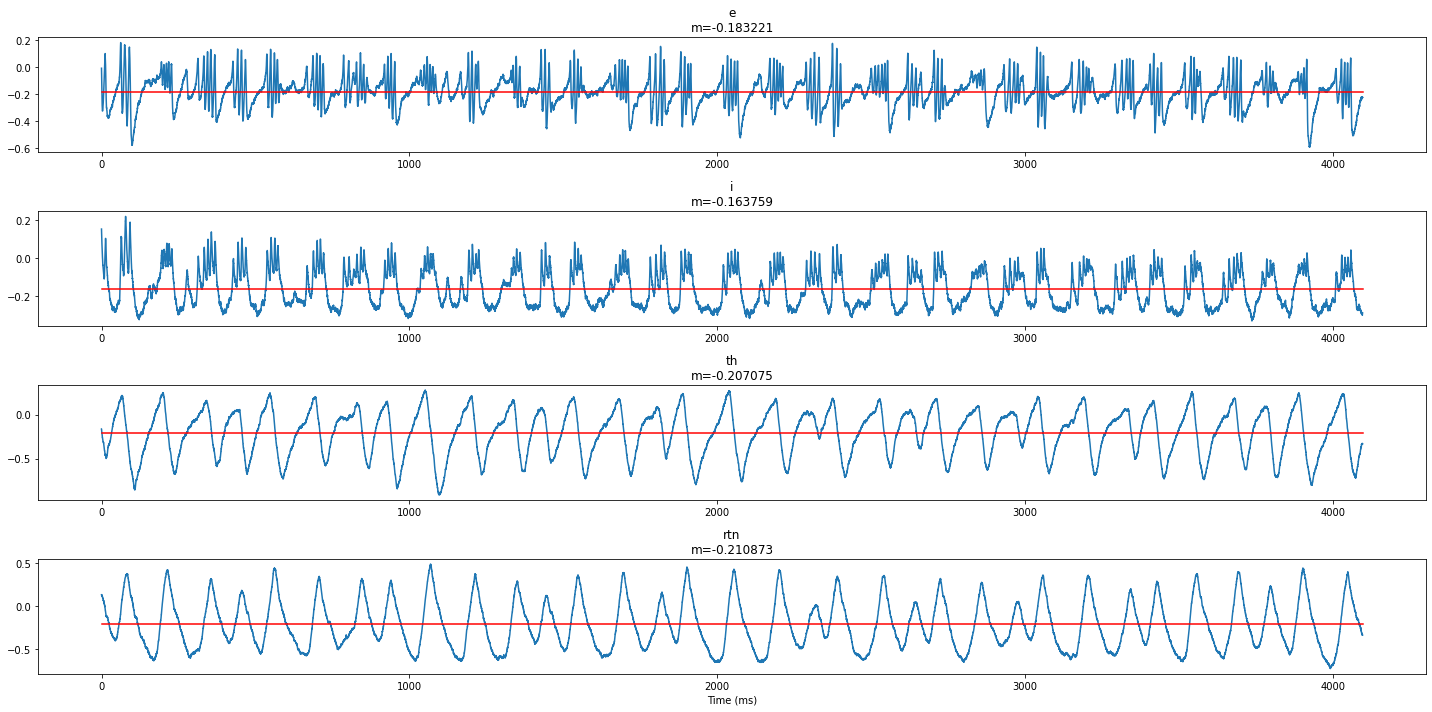

In [8]:
samples_fit_Gs, figaxes = model_sbi_fit(0)
samples.append(samples_fit_Gs)
figs.append(figaxes)

In [9]:
print(samples)

[{0.0: {'samples': array([[ 0.19705647, -0.16771176,  0.17433055],
       [ 0.24580315, -0.11557424,  0.275231  ],
       [ 0.3059082 , -0.27813676,  0.33563858],
       ...,
       [ 0.23505144, -0.15308234,  0.22052172],
       [ 0.11281959, -0.19311349,  0.24454981],
       [ 0.15010731, -0.07895384,  0.10252285]], dtype=float32), 'mean': array([ 0.23782939, -0.17091537,  0.24807142], dtype=float32)}, 0.5: {'samples': array([[ 0.23445956, -0.15584855,  0.09967986],
       [ 0.12122239, -0.14930302,  0.15363245],
       [ 0.27809092, -0.18781415,  0.2677637 ],
       ...,
       [ 0.31048355, -0.1664608 ,  0.25672865],
       [ 0.33681935, -0.23702617,  0.24682198],
       [ 0.16385235, -0.10618033,  0.20186627]], dtype=float32), 'mean': array([ 0.23348735, -0.21818103,  0.24372447], dtype=float32)}, 1.0: {'samples': array([[ 0.08244057, -0.60872436,  0.15640925],
       [ 0.08544363, -1.0367067 ,  0.15252392],
       [ 0.11616752, -0.38646328,  0.19410431],
       ...,
       [ 0.22

In [10]:
print(samples_fit_Gs[0])

{'samples': array([[ 0.19705647, -0.16771176,  0.17433055],
       [ 0.24580315, -0.11557424,  0.275231  ],
       [ 0.3059082 , -0.27813676,  0.33563858],
       ...,
       [ 0.23505144, -0.15308234,  0.22052172],
       [ 0.11281959, -0.19311349,  0.24454981],
       [ 0.15010731, -0.07895384,  0.10252285]], dtype=float32), 'mean': array([ 0.23782939, -0.17091537,  0.24807142], dtype=float32)}


In [11]:
print(samples_fit_Gs[0]["samples"].shape)

(3000, 3)




Fitting for G = 0.5!


 Run 0...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 40 epochs.
Done in 1637.75 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.23968777, 'i_e': -0.19102877, 'i_th': 0.26026812}

Plotting posterior...

Simulating with posterior means...

 Run 1...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 41 epochs.
Done in 1815.31 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.27468273, 'i_e': -0.23511314, 'i_th': 0.27626032}

Plotting posterior...

Simulating with posterior means...

 Run 2...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 39 epochs.
Done in 1767.42 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.26388088, 'i_e': -0.24622416, 'i_th': 0.2868333}

Plotting posterior...

Simulating with posterior means...

-----------------------------------------------------------------



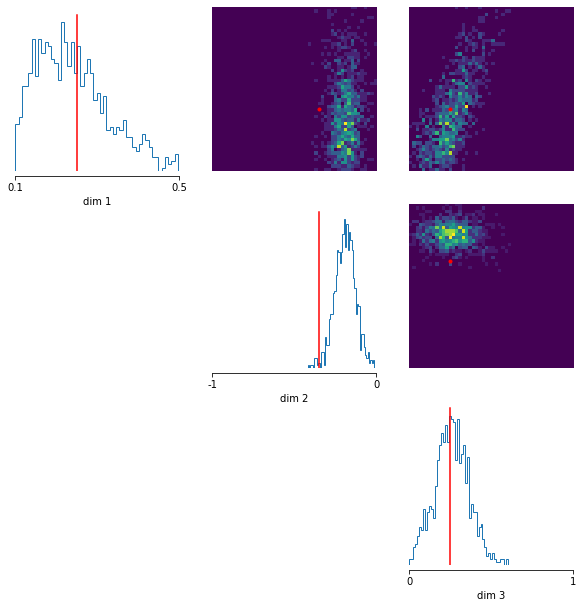

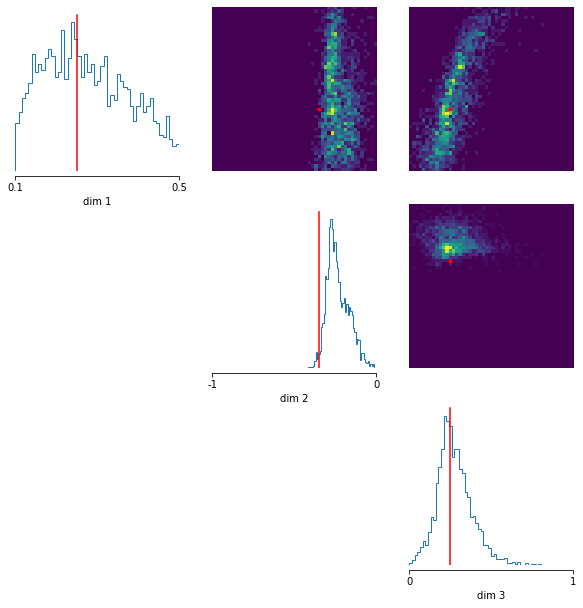

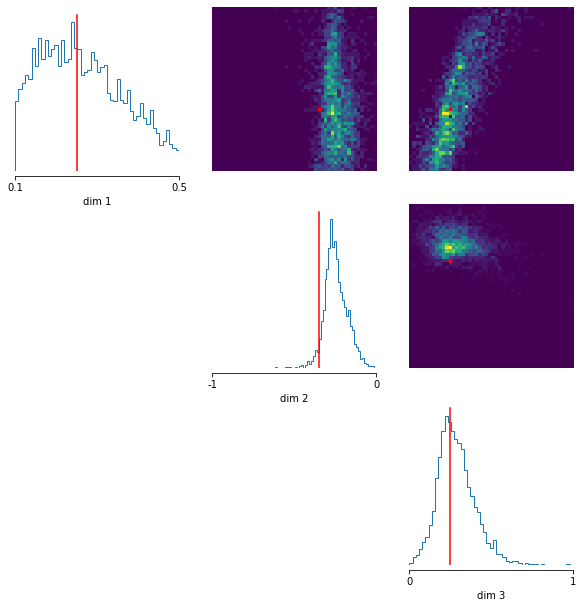

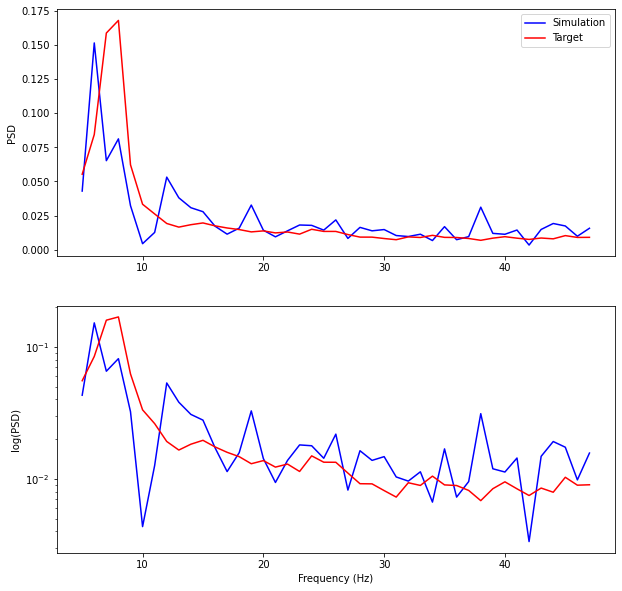

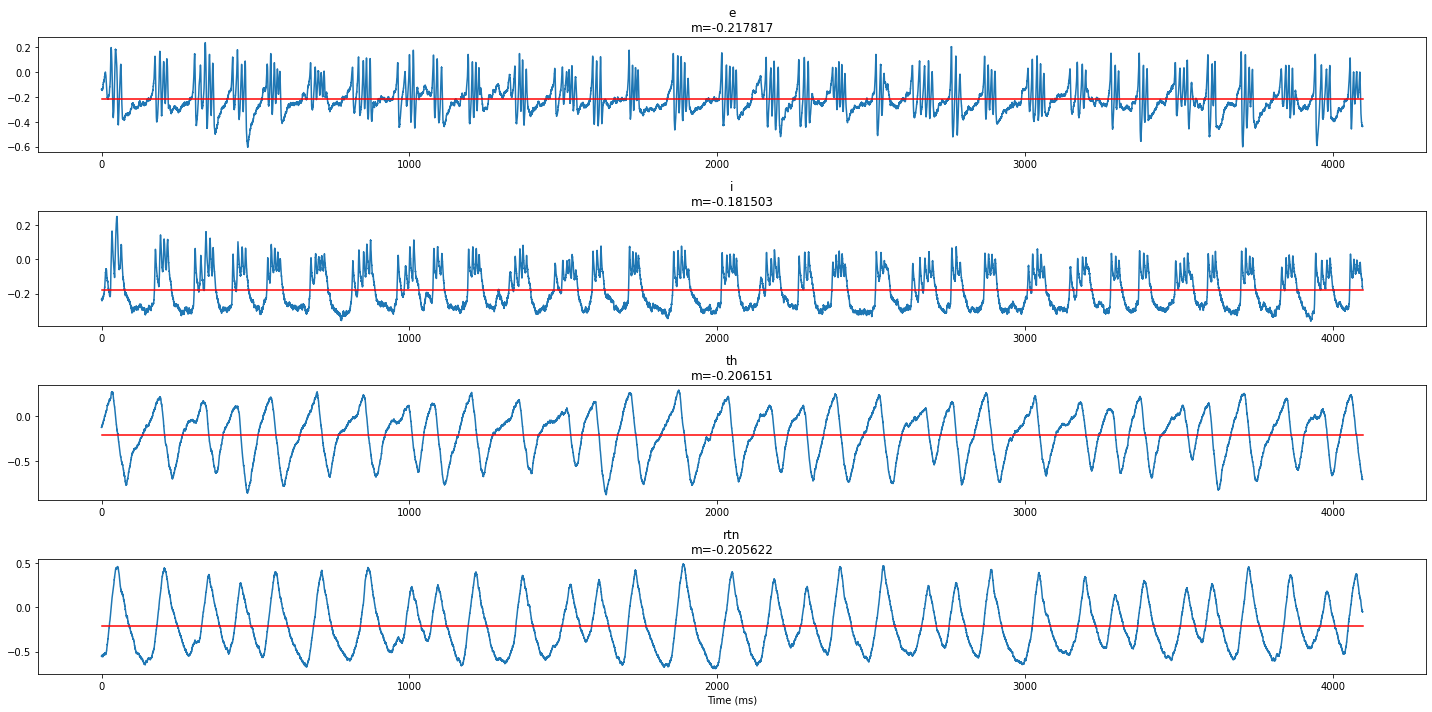

In [12]:
samples_fit_Gs, figaxes = model_sbi_fit(1)
samples.append(samples_fit_Gs)
figs.append(figaxes)




Fitting for G = 1!


 Run 0...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 32 epochs.
Done in 1285.57 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.3028391, 'i_e': -0.30926204, 'i_th': 0.27820343}

Plotting posterior...

Simulating with posterior means...

 Run 1...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 48 epochs.
Done in 1236.24 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.26156604, 'i_e': -0.33241573, 'i_th': 0.27078483}

Plotting posterior...

Simulating with posterior means...

 Run 2...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 45 epochs.
Done in 1227.59 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.2602506, 'i_e': -0.3132656, 'i_th': 0.26948568}

Plotting posterior...

Simulating with posterior means...

-----------------------------------------------------------------



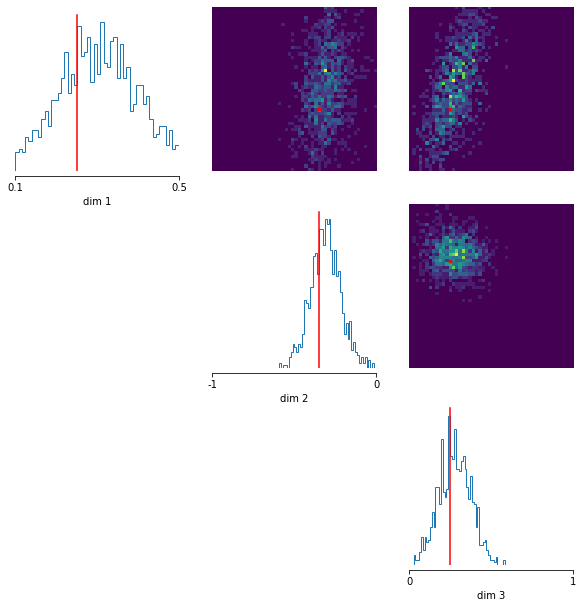

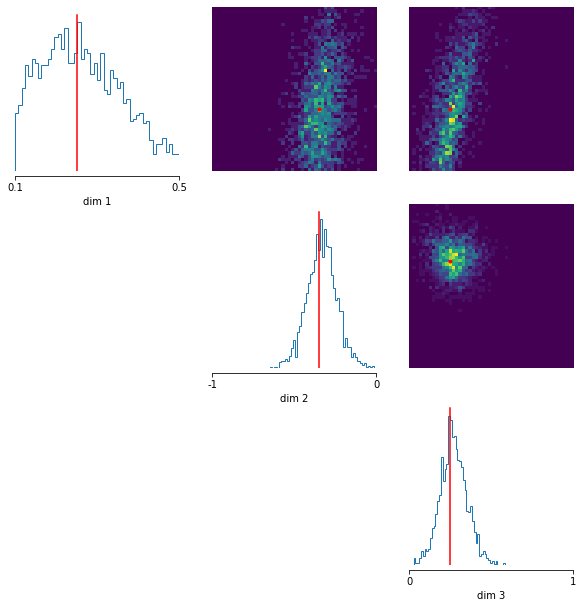

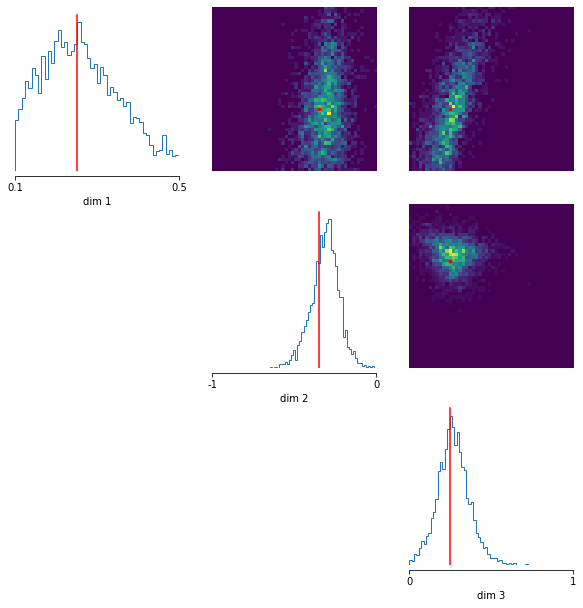

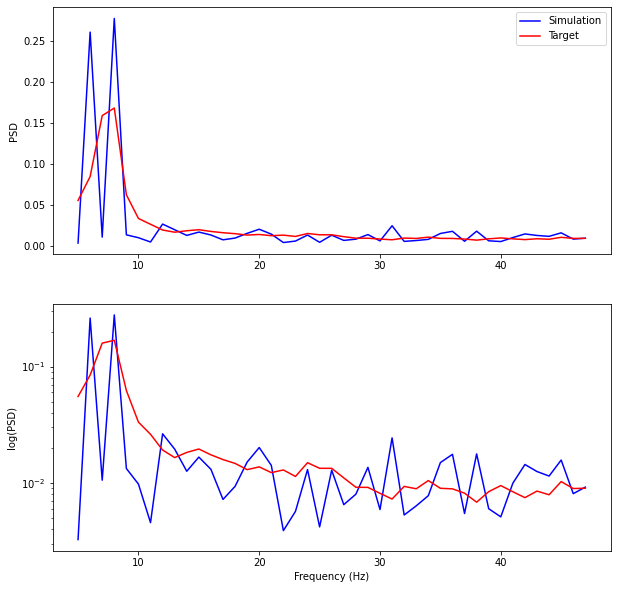

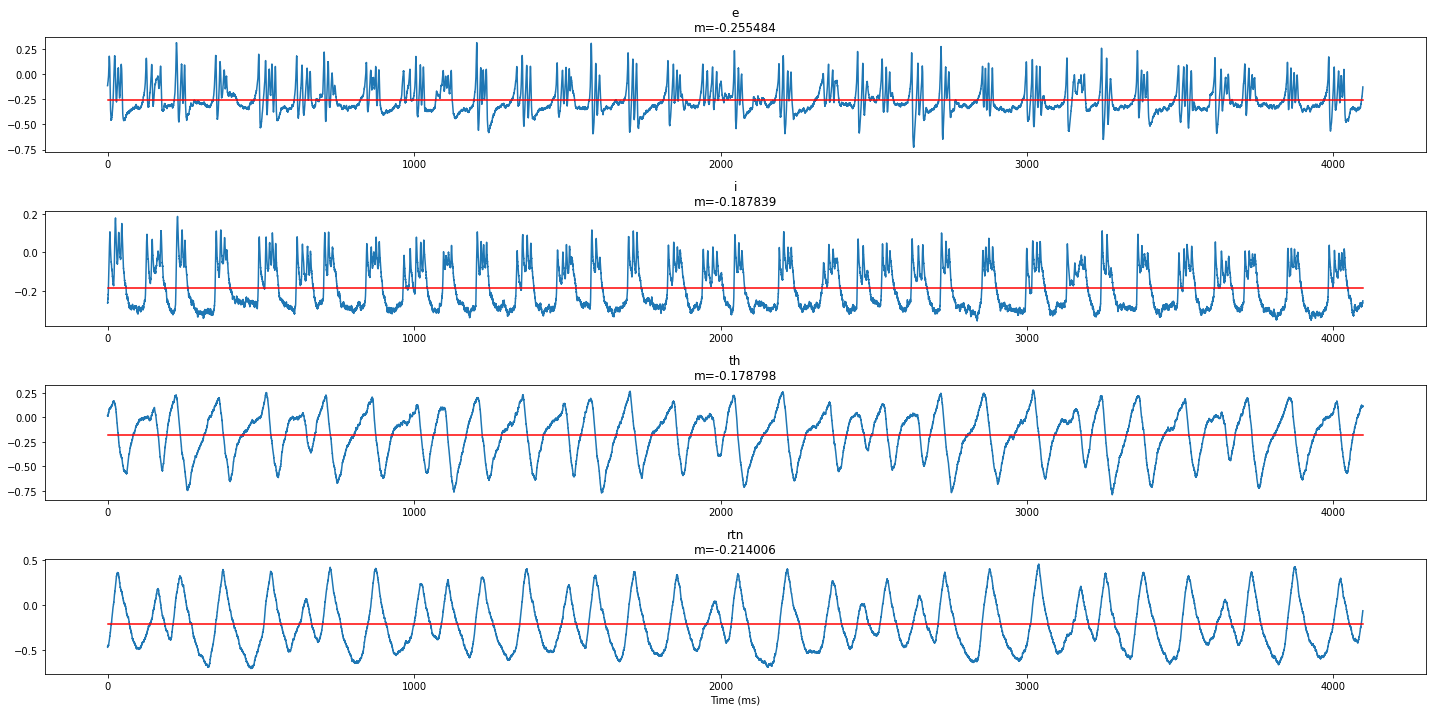

In [13]:
samples_fit_Gs, figaxes = model_sbi_fit(2)
samples.append(samples_fit_Gs)
figs.append(figaxes)




Fitting for G = 2!


 Run 0...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 48 epochs.
Done in 1222.41 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.3026205, 'i_e': -0.29233342, 'i_th': 0.28273794}

Plotting posterior...

Simulating with posterior means...

 Run 1...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 54 epochs.
Done in 1239.06 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.28377613, 'i_e': -0.31636518, 'i_th': 0.26012066}

Plotting posterior...

Simulating with posterior means...

 Run 2...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 42 epochs.
Done in 1220.97 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.29573005, 'i_e': -0.32535356, 'i_th': 0.2724946}

Plotting posterior...

Simulating with posterior means...

-----------------------------------------------------------------



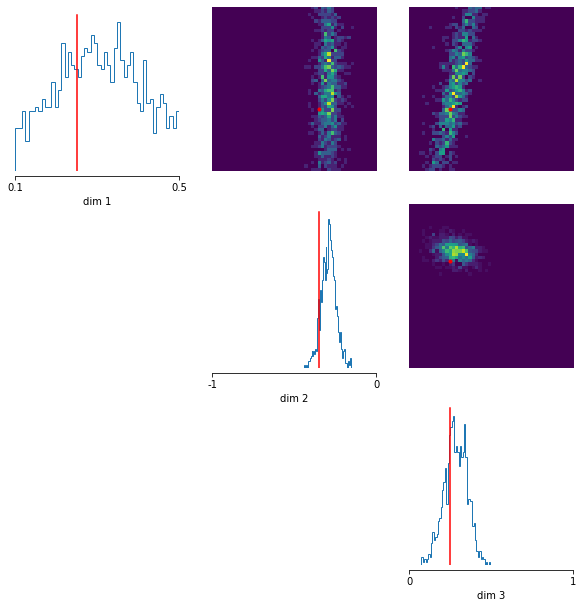

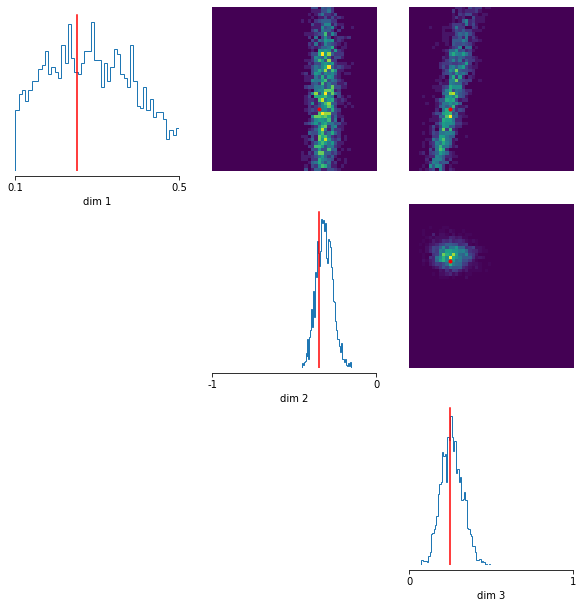

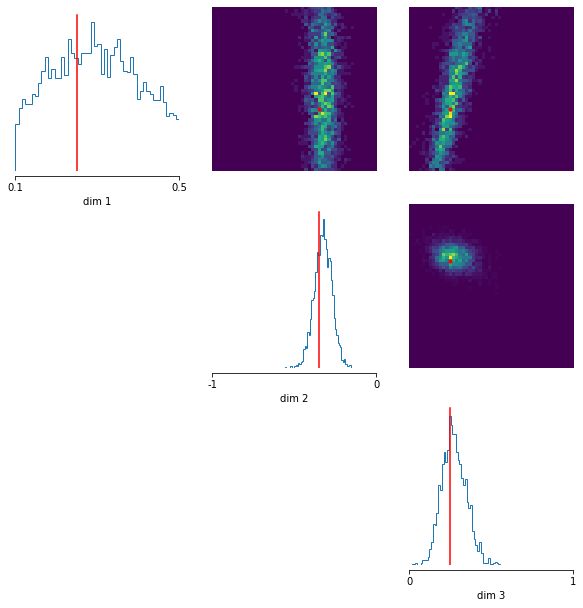

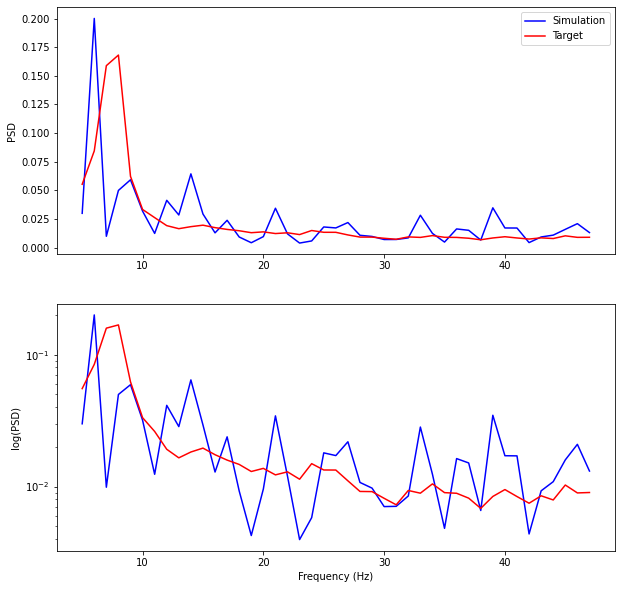

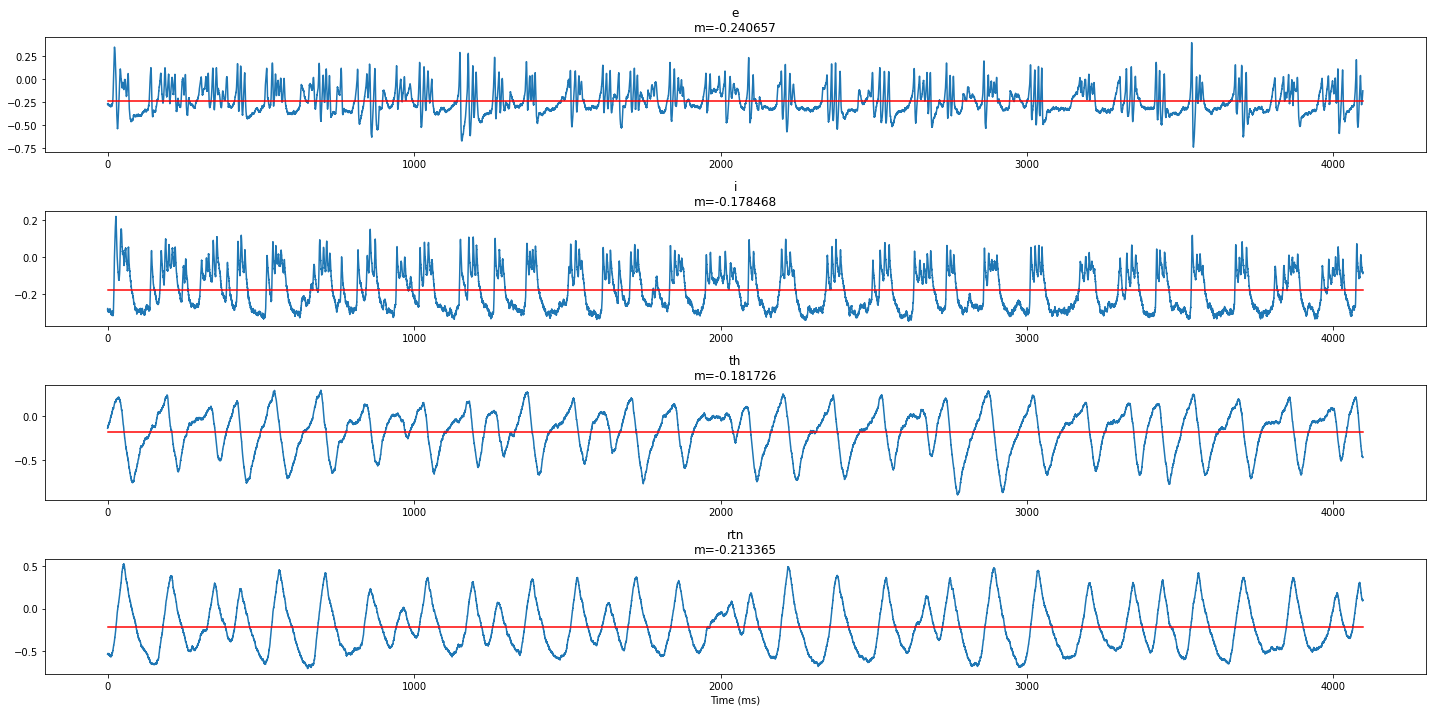

In [14]:
samples_fit_Gs, figaxes = model_sbi_fit(3)
samples.append(samples_fit_Gs)
figs.append(figaxes)



Fitting for G = 5!


 Run 0...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 52 epochs.
Done in 1195.02 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.26884222, 'i_e': -0.74952185, 'i_th': 0.31594932}

Plotting posterior...

Simulating with posterior means...

 Run 1...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 36 epochs.
Done in 1210.96 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.27085835, 'i_e': -0.7535348, 'i_th': 0.3032053}

Plotting posterior...

Simulating with posterior means...

 Run 2...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 38 epochs.
Done in 1372.43 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.26659185, 'i_e': -0.72132945, 'i_th': 0.28739977}

Plotting posterior...

Simulating with posterior means...

-----------------------------------------------------------------



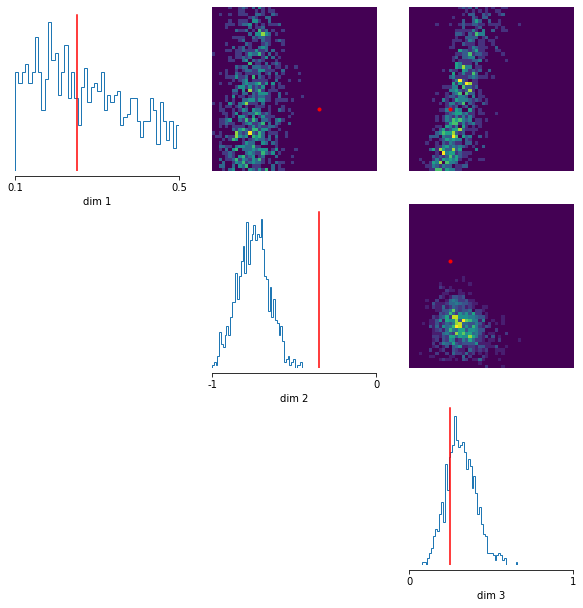

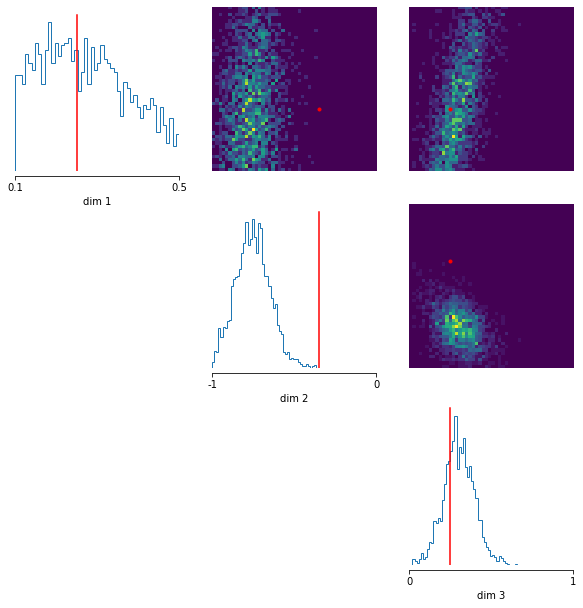

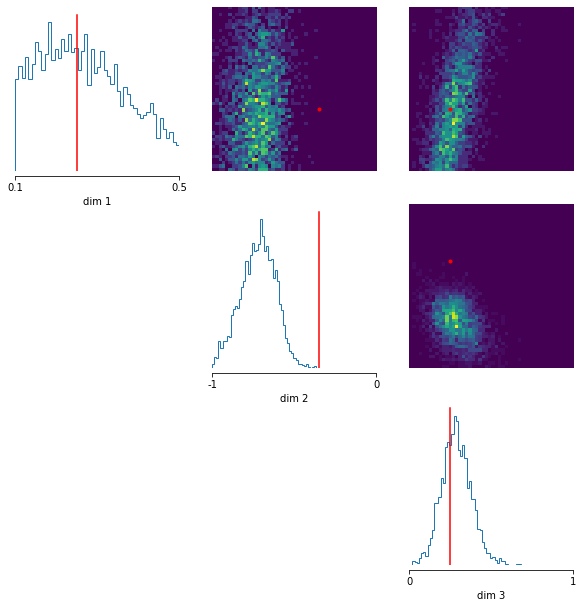

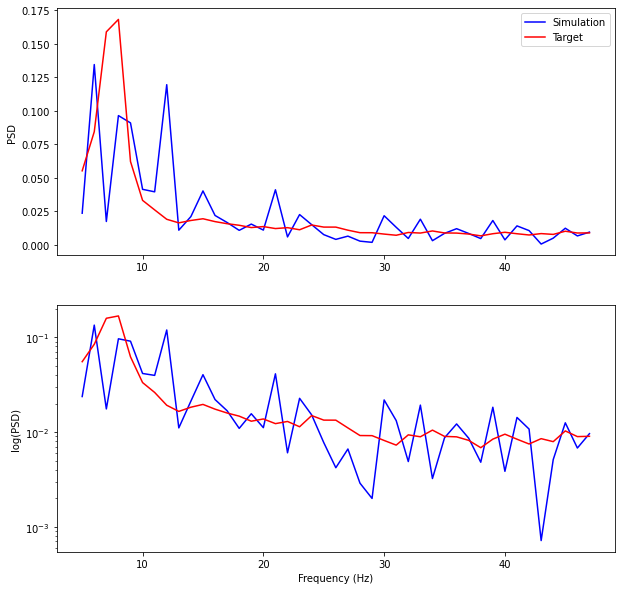

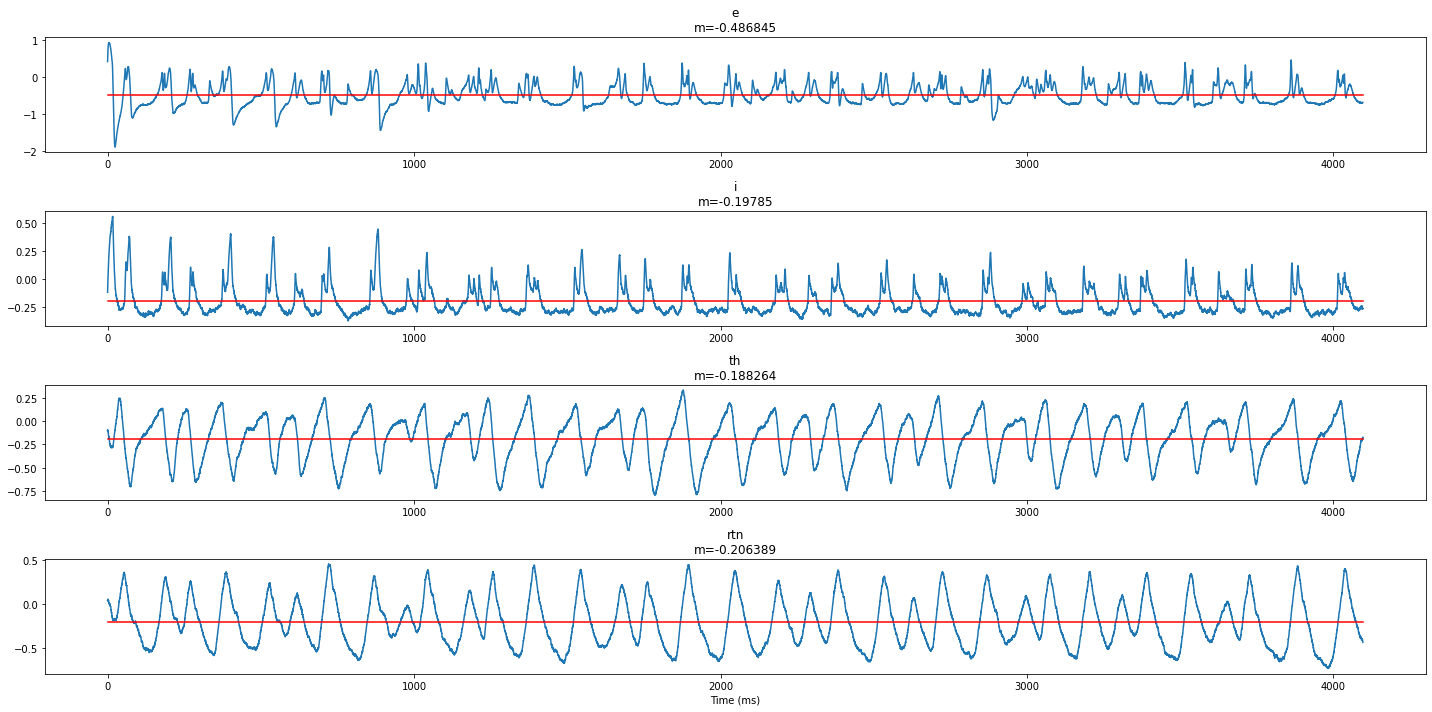

In [15]:
samples_fit_Gs, figaxes = model_sbi_fit(4)
samples.append(samples_fit_Gs)
figs.append(figaxes)



Fitting for G = 10!


 Run 0...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 48 epochs.
Done in 1576.88 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.20766464, 'i_e': -0.73581547, 'i_th': 0.16669188}

Plotting posterior...

Simulating with posterior means...

 Run 1...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 47 epochs.
Done in 2008.92 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.25948128, 'i_e': -0.7547992, 'i_th': 0.20559713}

Plotting posterior...

Simulating with posterior means...

 Run 2...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 48 epochs.
Done in 1745.99 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.27759162, 'i_e': -0.7951977, 'i_th': 0.25976667}

Plotting posterior...

Simulating with posterior means...

-----------------------------------------------------------------



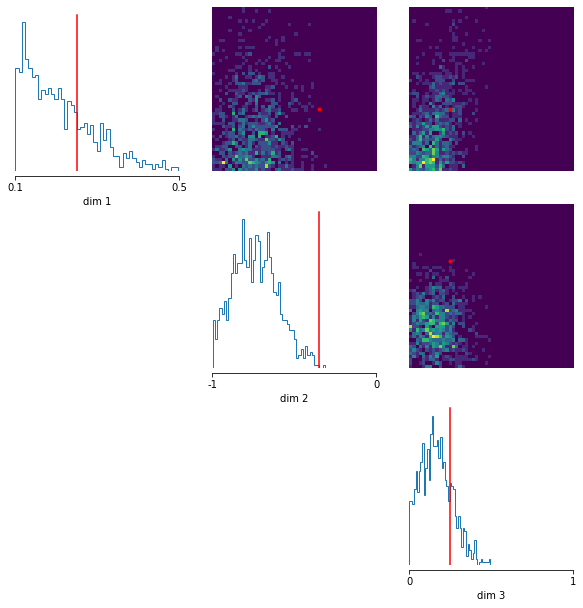

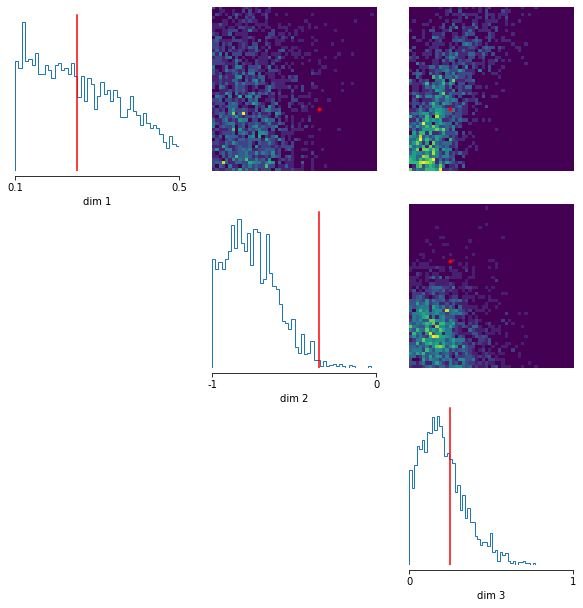

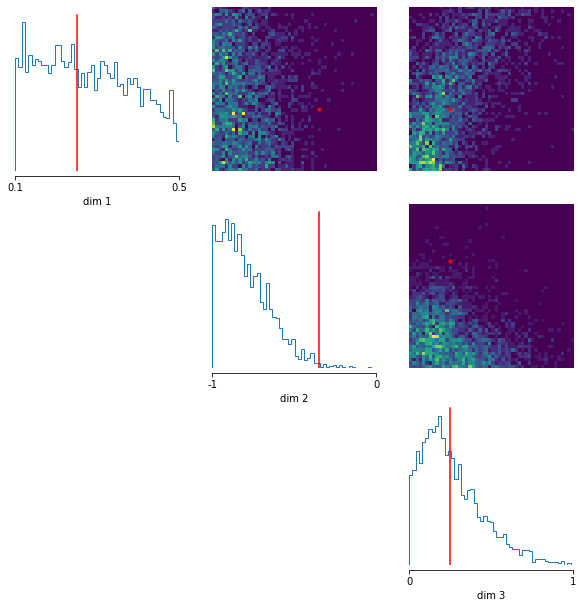

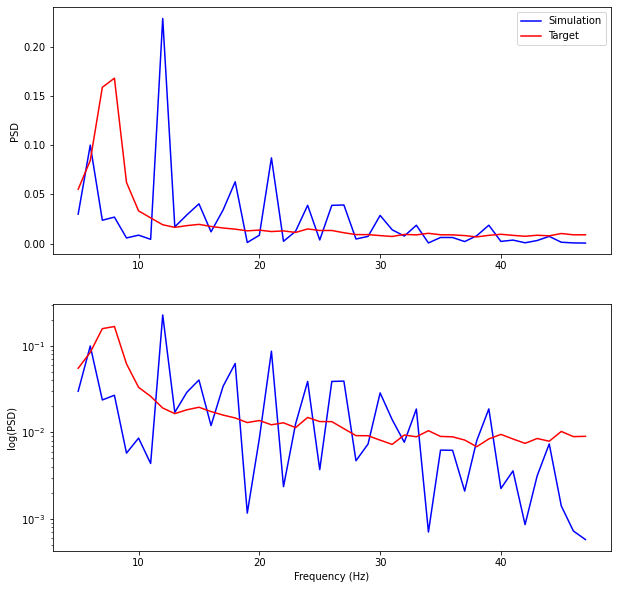

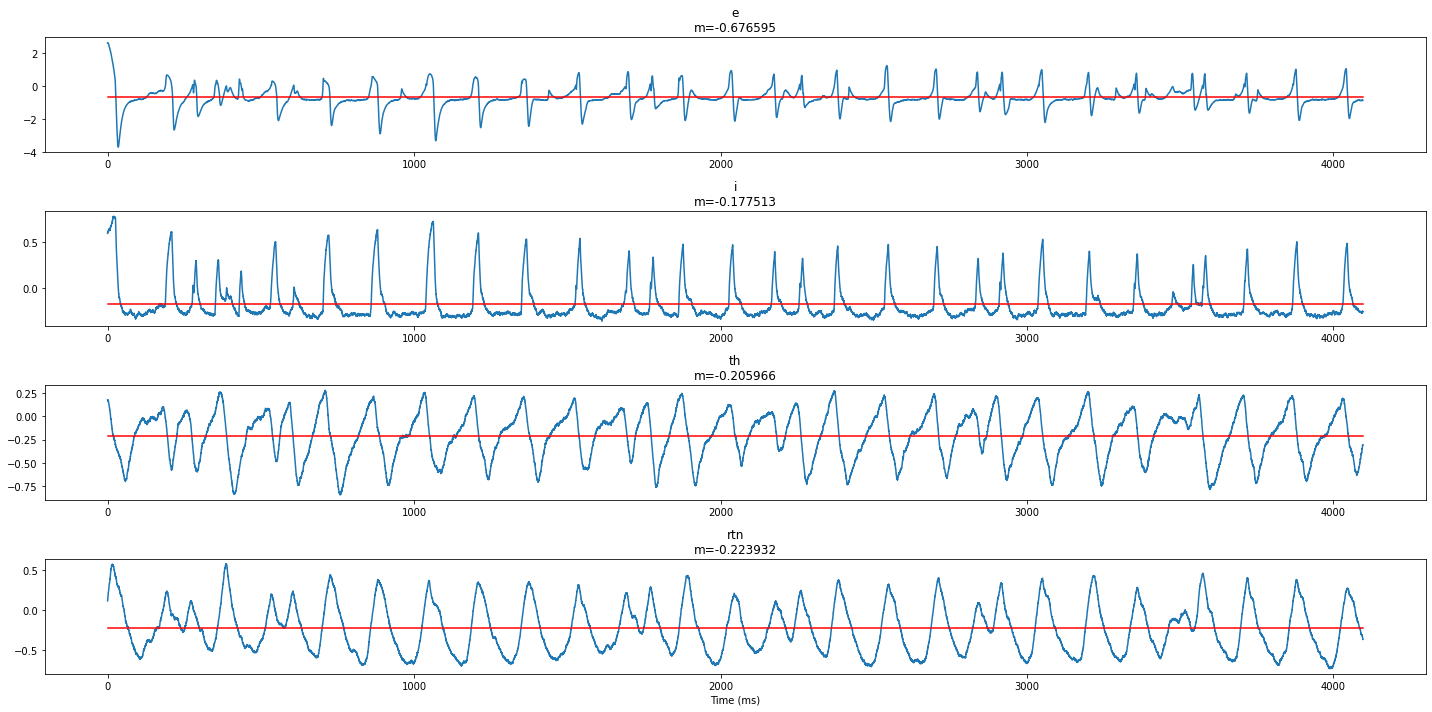

In [16]:
samples_fit_Gs, figaxes = model_sbi_fit(5)
samples.append(samples_fit_Gs)
figs.append(figaxes)



Fitting for G = 15!


 Run 0...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 32 epochs.
Done in 1452.65 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.2909127, 'i_e': -0.74394083, 'i_th': 0.40817577}

Plotting posterior...

Simulating with posterior means...

 Run 1...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 43 epochs.
Done in 2108.94 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.29000044, 'i_e': -0.7745675, 'i_th': 0.3158946}

Plotting posterior...

Simulating with posterior means...

 Run 2...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 41 epochs.
Done in 4017.46 sec!

Sampling posterior...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Samples' mean:
{'stim_amp': 0.28973392, 'i_e': -0.6866416, 'i_th': 0.27690238}

Plotting posterior...

Simulating with posterior means...

-----------------------------------------------------------------



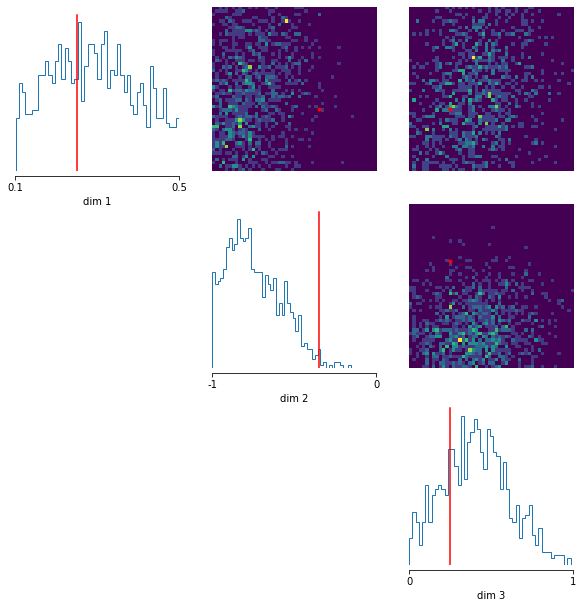

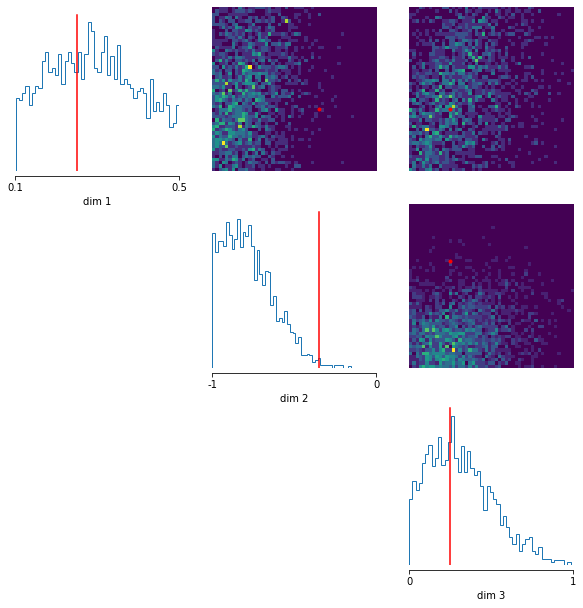

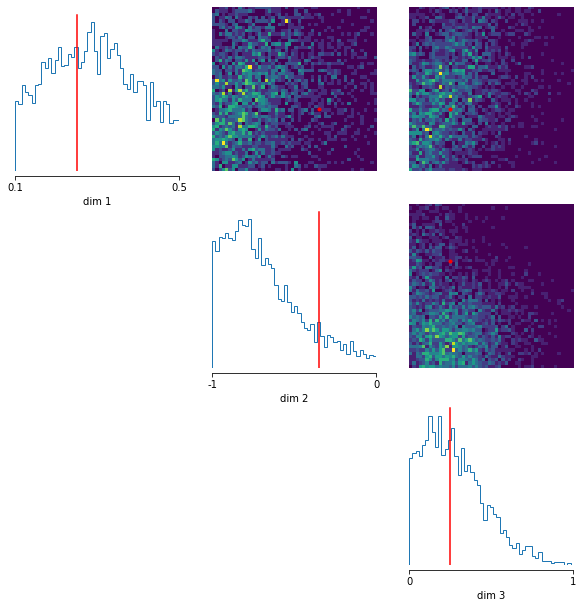

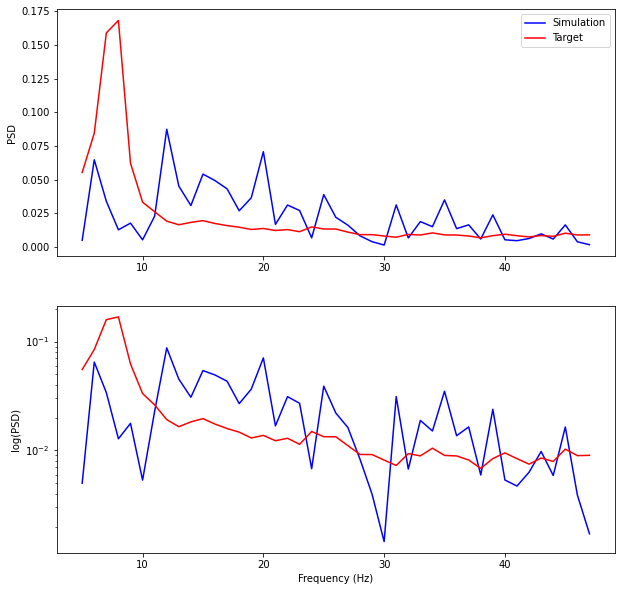

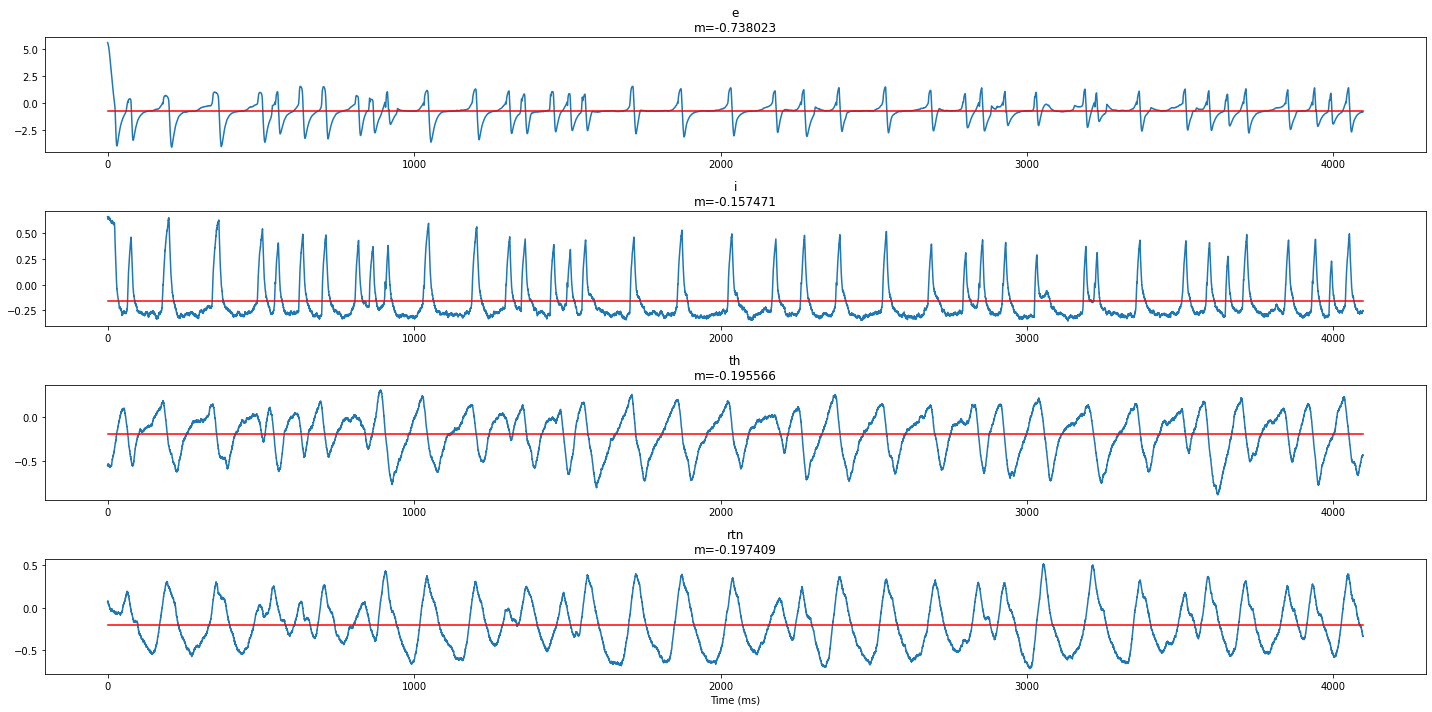

In [17]:
samples_fit_Gs, figaxes = model_sbi_fit(6)
samples.append(samples_fit_Gs)
figs.append(figaxes)

In [18]:
samples_fit_Gs, figaxes = model_sbi_fit(7)
samples.append(samples_fit_Gs)
figs.append(figaxes)



Fitting for G = 20!


 Run 0...



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
samples_fit_Gs, figaxes = model_sbi_fit(8)
samples.append(samples_fit_Gs)
figs.append(figaxes)

In [ ]:
samples_fit_Gs, figaxes = model_sbi_fit(9)
samples.append(samples_fit_Gs)
figs.append(figaxes)

In [ ]:
samples_fit_Gs, figaxes = model_sbi_fit(10)
samples.append(samples_fit_Gs)
figs.append(figaxes)